In [37]:
from custommodels.SpreadingModels import CascadeModel, ClassicalModel, ThresholdModel, SIRModelBase
from custommodels.Pickle import load
import networkx as nx
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
random.seed(1337)

In [38]:
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph())
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [39]:
sorted_degree = load('sorted_degree')
betweenness_centrality = load('betweenness_centrality')
sorted_betweenness = sorted(list(betweenness_centrality.items()), key=lambda x: x[1], reverse=True)
print(sorted_degree[:10])
print(sorted_betweenness[:10])

Found data, loading from picklejar
Found data, loading from picklejar
[(40, 1134), (44, 1055), (108, 854), (116, 838), (159, 833), (36, 779), (191, 732), (49, 569), (634, 550), (156, 475)]
[(40, 0.12403234435146233), (191, 0.0652084687505221), (159, 0.055154823184804594), (108, 0.048552931583974356), (44, 0.04550912157860133), (36, 0.040196157255756634), (116, 0.04007702651128203), (35, 0.02498508521877784), (49, 0.02024941838392064), (405, 0.016928145463064457)]


In [40]:
def get_starter_nodes():
    top_10_degree = [str(node) for node, _ in sorted_degree[:10]]
    top_10_betweenness = [str(node) for node, _ in sorted_betweenness[:10]]
    random_10 = random.sample(list(G.nodes()), 10)
    random_10 = [str(node) for node in random_10]
    return top_10_degree, top_10_betweenness, random_10

def results_to_noderatios(results, num_initial_infected, G):
    # results is a list of tuples (new_state: dict, newly_infected: list, newly_recovered: list)
    # this turns it into a list of lists, [susceptible: int[], infected: int[], recovered: int[]]
    # the 0th element in each list is the first step, the 1st element is the second step, etc.
    n = len(G.nodes)
    num_susceptible = [n - num_initial_infected]
    num_infected = [num_initial_infected]
    num_recovered = [0]
    for state, i, r in results:
        num_susceptible.append(list(state.values()).count(0))
        num_infected.append(list(state.values()).count(1))
        num_recovered.append(list(state.values()).count(2))
    return np.array(num_susceptible)/n, np.array(num_infected)/n, np.array(num_recovered)/n


In [41]:
def plot_three_graphs(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100):
    degree, betweenness, random = get_starter_nodes()
    degree_model = deepcopy(model)
    betweenness_model = deepcopy(model)
    random_model = deepcopy(model)

    degree_model.set_initial_infected(degree)
    betweenness_model.set_initial_infected(betweenness)
    random_model.set_initial_infected(random)

    degree_results = results_to_noderatios(degree_model.iterate(iterations), len(degree), G)
    betweenness_results = results_to_noderatios(betweenness_model.iterate(iterations), len(betweenness), G)
    random_results = results_to_noderatios(random_model.iterate(iterations), len(random), G)
    
    model_results = (degree_results, betweenness_results, random_results)
    model_names = (f'Top {len(degree)} Degree', f'Top {len(betweenness)} Betweenness', f'{len(random)} Random')
    model_colors = ('lightcoral', 'firebrick', 'orangered') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Infected", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

# Cascade

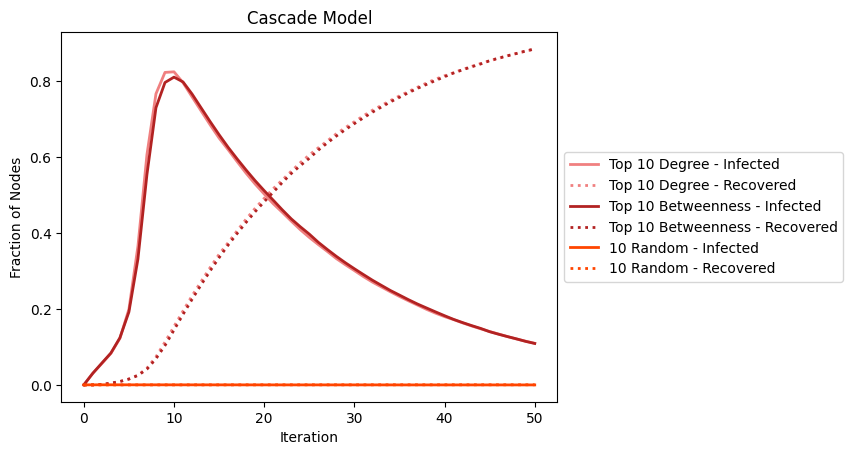

In [42]:
model = CascadeModel(G)
beta, gamma = 0.15, 0.05
model.set_parameters(beta, gamma)

plot_three_graphs(
    model, 
    title='Cascade Model', 
    iterations=50,
    infected=True,
    # susceptible=True,
    recovered=True
)